In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam

from ann_utils import *

In [2]:
preproc_folder = "enriched_time"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
output_path = "../data/models/"

prefix = 'time_2018-04-30_imp_bg_'
postfix = '_190721_170'
trainfile = '_traindata'
testfile = '_testdata'

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix+trainfile+postfix+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix+testfile+postfix+'.pkl') 

In [3]:
len(feature_labels)

35

In [64]:
mlp = create_mlp_model(len(feature_labels), 4, [45,30, 25, 5], [tf.nn.relu]*4,                                        #35, 2, [20, 5], [tf.nn.relu, tf.nn.relu],
                      optimizer = Adam(),
                      loss_func="binary_crossentropy",
                      #kernel_regularizers = [l2(0.001)]*3,
                      dropout = [0.5]*4,
                      metrics = ['accuracy',tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 45)                1620      
_________________________________________________________________
dropout_16 (Dropout)         (None, 45)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 30)                1380      
_________________________________________________________________
dropout_17 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 25)                775       
_________________________________________________________________
dropout_18 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                

In [65]:
X_train.shape

(46101, 35)

In [66]:
early_stopping = TerminateOnBaseline(monitor='auc'+mlp.name.split('sequential')[-1] #keep track of the model name adding the postfix to the metric to monitor
                                     , baseline=0.9)
batch_size = 256
epochs=100

#creating validation data
validation_size = 5000

X_val = X_train[:validation_size]
partial_X_train = X_train[validation_size:]
y_val = y_train[:validation_size]
partial_y_train = y_train[validation_size:]

history = mlp.fit(partial_X_train, partial_y_train, epochs=epochs,  batch_size = batch_size, verbose=1, 
        steps_per_epoch=math.ceil(X_train.shape[0]/batch_size), callbacks=[early_stopping],
                 validation_data=(X_val, y_val), class_weight={0:1, 1:50})
        

Epoch 1/100
181/181 [==============================] - 24s 134ms/step - loss: 1.2190 - accuracy: 0.7084 - auc_6: 0.6157 - precision_7: 0.0250 - recall_7: 0.4658 - val_loss: 0.6024 - val_accuracy: 0.8868 - val_auc_6: 0.7620 - val_precision_7: 0.0587 - val_recall_7: 0.4714
Epoch 2/100
181/181 [==============================] - 24s 132ms/step - loss: 1.0252 - accuracy: 0.8915 - auc_6: 0.7502 - precision_7: 0.0699 - recall_7: 0.4849 - val_loss: 0.4973 - val_accuracy: 0.9176 - val_auc_6: 0.8273 - val_precision_7: 0.0929 - val_recall_7: 0.5571
Epoch 3/100
181/181 [==============================] - 24s 132ms/step - loss: 0.9305 - accuracy: 0.8993 - auc_6: 0.8161 - precision_7: 0.0889 - recall_7: 0.5911 - val_loss: 0.4229 - val_accuracy: 0.9000 - val_auc_6: 0.8358 - val_precision_7: 0.0833 - val_recall_7: 0.6143
Epoch 4/100
181/181 [==============================] - 24s 132ms/step - loss: 0.8556 - accuracy: 0.8970 - auc_6: 0.8548 - precision_7: 0.0964 - recall_7: 0.6703 - val_loss: 0.3574 - va

In [67]:
history_dict = history.history

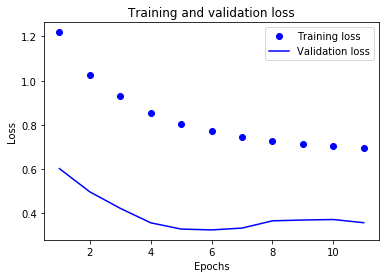

In [68]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

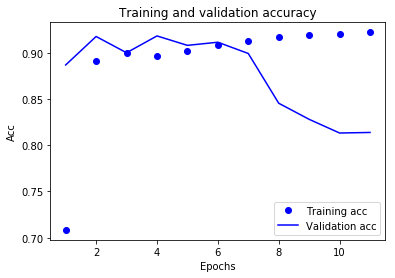

In [69]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend()

plt.show()

In [70]:
predictions = mlp.predict(X_test)

In [71]:
predictions.round()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [72]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
fpr, tpr, thresholds = roc_curve(y_test, predictions) #false positive rate, true positive rate and thresholds
auc = roc_auc_score(y_test, predictions)
        
print('AUC: {}'.format(auc))

AUC: 0.8773888269586742
